# Curate results of spike sorting

Notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- 2-curate_acoustics
- 3-sort_spikes
- **4-curate_spikes**

Use the environment **spikeproc** to run this notebook

If necessary, SpikeInterface has a [method](https://spikeinterface.readthedocs.io/en/stable/modules/sorters.html) to concatenate multi-segment recordings 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import spikeinterface.full as si
import traceback

import sys
sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
from ceciestunepipe.mods import spike_util as su

# si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)

In [2]:
pip show spikeinterface

Name: spikeinterface
Version: 0.101.0
Summary: Python toolkit for analysis, visualization, and comparison of spike sorting output
Home-page: 
Author: 
Author-email: Alessio Buccino <alessiop.buccino@gmail.com>, Samuel Garcia <sam.garcia.die@gmail.com>
License: 
Location: /mnt/cube/lo/envs/spikeproc101/lib/python3.8/site-packages
Requires: neo, numpy, packaging, probeinterface, threadpoolctl, tqdm, zarr
Required-by: sortingview
Note: you may need to restart the kernel to use updated packages.


## Set parameters

In [3]:
sess_par = {
    'bird':'z_r12r13_21', # bird ID
    'sess':'2021-06-28', # session date
    'probe':{'probe_type':'neuropixels-1.0'}, # probe specs
    'epoch':'0701_g0', # epoch
    'ephys_software':'sglx', # recording software, sglx or oe
    'sorter':'kilosort4', # spike sorting algorithm
    'sort':'sort_0', # sort index
}

In [4]:
# Probe absolute location (unit locations are relative)
# SI formatting: probe width (x), depth (y), othogonal (z)
# Assuming flat of probe extends M/L, foot is anterior, and vertical implant, use:
# M/L (x), D/V (y), A/P (z) -- units are um
# Typical HVC-RA implant: [2200, 4300, 300]
probe_abs_loc = np.array([2200, 4300, 300])

## Load data

In [5]:
sort_dir = '/mnt/cube/chronic_ephys/der/{}/{}/{}/{}/{}/{}/'.format(
    sess_par['bird'],sess_par['sess'],sess_par['ephys_software'],
    sess_par['epoch'],sess_par['sorter'],sess_par['sort'])
sess_par, sort_dir

({'bird': 'z_r12r13_21',
  'sess': '2021-06-28',
  'probe': {'probe_type': 'neuropixels-1.0'},
  'epoch': '0701_g0',
  'ephys_software': 'sglx',
  'sorter': 'kilosort4',
  'sort': 'sort_0'},
 '/mnt/cube/chronic_ephys/der/z_r12r13_21/2021-06-28/sglx/0701_g0/kilosort4/sort_0/')

In [6]:
sort_path = sort_dir + 'sorter_output/'
analyzer_path = sort_dir + 'sorting_analyzer/'
waveforms_path = sort_dir + 'waveforms/'

# Spike interface version ≥ 0.101.0
if os.path.exists(analyzer_path):
    print('loading sorting analyzer..')
    use_analyzer_not_wave = True
    metrics_path = analyzer_path + 'extensions/quality_metrics/metrics.csv'
    analyzer = si.load_sorting_analyzer(analyzer_path)
# Spike interface version < 0.101.0
else:
    if os.path.exists(waveforms_path):
        print('loading waveforms..')
        use_analyzer_not_wave = False
        metrics_path = waveforms_path + 'quality_metrics/metrics.csv'
        analyzer = si.load_waveforms(waveforms_path)
    else: print('no analyzer or waveforms..')

loading sorting analyzer..


## Compute quality metrics
- [ISI violations](https://spikeinterface.readthedocs.io/en/stable/modules/qualitymetrics/isi_violations.html)
- [SNR](https://spikeinterface.readthedocs.io/en/stable/modules/qualitymetrics/snr.html)
- [Presence ratio](https://spikeinterface.readthedocs.io/en/stable/modules/qualitymetrics/presence_ratio.html)

In [7]:
# Thresholds for quality metric curation
ISI_VR_THRESH = [0.1,0.5]
SNR_THRESH = [1,2]
PRESENCE_THRESH = [0.05,0.95]

In [8]:
# Load metrics
metrics_pd = pd.read_csv(metrics_path)
try: metrics_pd.drop(columns=['Unnamed: 0'], inplace=True)
except: pass

# # Remove NaN metrics
# metrics_list = [key for key in metrics_pd.keys() if not metrics_pd[key].isna().any()]
metrics_list = metrics_pd.keys().tolist()

# Store quality metrics in sorting analyzer
for this_metric in metrics_list:
    analyzer.sorting.set_property(this_metric,metrics_pd[this_metric].values)

# Set ISI violations threshold
isi_vr_label = np.full(analyzer.sorting.get_num_units(),'l')
isi_vr_label[np.where((analyzer.sorting.get_property('isi_violations_ratio') > ISI_VR_THRESH[0]) & 
                (analyzer.sorting.get_property('isi_violations_ratio') < ISI_VR_THRESH[1]))[0]] = 'm'
isi_vr_label[np.where(analyzer.sorting.get_property('isi_violations_ratio') > ISI_VR_THRESH[1])[0]] = 'h'  
analyzer.sorting.set_property('isi_vr_thresh', isi_vr_label)

# Set SNR threshold
snr_label = np.full(analyzer.sorting.get_num_units(),'l')
snr_label[np.where((analyzer.sorting.get_property('snr') > SNR_THRESH[0]) & 
                (analyzer.sorting.get_property('snr') < SNR_THRESH[1]))[0]] = 'm'
snr_label[np.where(analyzer.sorting.get_property('snr') > SNR_THRESH[1])[0]] = 'h' 
analyzer.sorting.set_property('snr_thresh', snr_label)

# Set presence ratio threshold
presence_label = np.full(analyzer.sorting.get_num_units(),'l')
presence_label[np.where((analyzer.sorting.get_property('presence_ratio') > PRESENCE_THRESH[0]) & 
                (analyzer.sorting.get_property('presence_ratio') < PRESENCE_THRESH[1]))[0]] = 'm'
presence_label[np.where(analyzer.sorting.get_property('presence_ratio') > PRESENCE_THRESH[1])[0]] = 'h' 
analyzer.sorting.set_property('presence_thresh', presence_label)

# Set quality labels according to thresholds for quality metric curation
quality_labels = np.full(analyzer.sorting.get_num_units(),'_____')
quality_labels[np.where(isi_vr_label == 'h')[0]] = 'mua_4'
quality_labels[np.where((isi_vr_label == 'l') & (snr_label == 'h'))[0]] = 'sua_1'
quality_labels[np.where((isi_vr_label == 'l') & (snr_label == 'm'))[0]] = 'sua_2'
quality_labels[np.where((isi_vr_label == 'm') & (snr_label == 'h'))[0]] = 'sua_2'
quality_labels[np.where((isi_vr_label == 'm') & (snr_label == 'm'))[0]] = 'sua_3'
quality_labels[np.where(snr_label == 'l')[0]] = 'noise'
quality_labels[np.where(presence_label == 'l')[0]] = 'noise'
analyzer.sorting.set_property('quality_labels', quality_labels)

su.print_unit_counts(quality_labels)
print(analyzer.sorting); print(analyzer)

sua_1: 92
sua_2: 180
sua_3: 180
mua_4: 444
noise: 48
total: 779
NumpySorting: 779 units - 1 segments - 30.0kHz
SortingAnalyzer: 384 channels - 779 units - 1 segments - binary_folder - sparse - has recording
Loaded 14 extensions: template_similarity, template_metrics, amplitude_scalings, correlograms, principal_components, spike_amplitudes, random_spikes, spike_locations, waveforms, quality_metrics, templates, isi_histograms, unit_locations, noise_levels


## Get and store auto merges

In [9]:
%%time
merges_auto_init_all = []
merges_auto_all = []
sort_auto_all = []

presets_all = ['similarity_correlograms','x_contaminations','temporal_splits','feature_neighbors']
for this_preset in presets_all:
    try:
        print(this_preset + '..')
        merges_auto_init = si.get_potential_auto_merge(analyzer, preset=this_preset)
        merges_auto = su.merge_lists(merges_auto_init)
        print(merges_auto)
        if len(merges_auto) > 0: sort_auto = si.MergeUnitsSorting(analyzer.sorting, merges_auto)
        else: sort_auto = analyzer.sorting
        print(sort_auto,'\n')

        merges_auto_init_all.append(merges_auto_init)
        merges_auto_all.append(merges_auto)
        sort_auto_all.append(sort_auto)
    except Exception as e:
        print('WARNING,',this_preset,'failed:', e)
        print(traceback.format_exc())

similarity_correlograms..
[[227, 237], [363, 397]]
MergeUnitsSorting: 777 units - 1 segments - 30.0kHz 

x_contaminations..
[[120, 113], [178, 179, 182, 173], [187, 189], [227, 237], [282, 283], [297, 301, 303], [363, 397], [602, 365], [576, 660], [594, 591], [701, 695]]
MergeUnitsSorting: 765 units - 1 segments - 30.0kHz 

temporal_splits..
[[120, 113], [178, 179, 182, 173], [187, 189], [282, 283], [297, 301, 303], [576, 660]]
MergeUnitsSorting: 770 units - 1 segments - 30.0kHz 

feature_neighbors..
[[194, 764, 10, 397, 206, 400, 659, 597, 602, 347, 546, 227, 547, 567, 358, 363, 237, 365, 369, 371, 564, 695, 380, 701], [19], [20], [22], [23], [29], [31], [32], [34], [36], [37], [41], [42], [45], [46], [49], [50], [52], [54], [55], [56], [57], [61], [62], [65], [69], [71], [72], [73], [74], [80], [84], [86], [91], [94], [99], [100], [101], [105], [106], [107], [120, 113], [114], [117], [119], [121], [122], [123], [125], [128], [134], [137], [144], [146], [147], [149], [155], [157], [15

## Curate spikes
Using the [SpikeInterface](https://spikeinterface.readthedocs.io/en/latest/) [web-based](https://github.com/SpikeInterface/spikeinterface) [viewer](https://github.com/magland/sortingview)

In [11]:
unit_table_properties = ['quality_labels','KSLabel','isi_violations_ratio','snr','num_spikes']
label_choices = ['sua_1','sua_2','sua_3','mua_4','noise']
pss = si.plot_sorting_summary(analyzer, curation=True, backend='sortingview', label_choices=label_choices,
                              unit_table_properties=['quality_labels','KSLabel','isi_violations_ratio','num_spikes'])

Computing sha1 of /home/AD/lostrows/.kachery-cloud/tmp_SVO7yy8J/file.dat
https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://20c0f11be0e85a5973267f116da7899790deb345


## Import curated sorts...
When complete, click the button labeled `Save as snapshot (sha1://)` and paste the link below to generate sort_curated, a [sorting](https://spikeinterface.readthedocs.io/en/latest/api.html#spikeinterface.core.BaseSorting) [object](https://github.com/SpikeInterface/spikeinterface/blob/25bb836601e3ec358a06dcb73be34699d8065faf/src/spikeinterface/core/basesorting.py)

In [12]:
sha_uri = 'sha1://4d706ae5288229ac6dce94a94001f957d5affbe8'

In [13]:
# get curation
sort_curated = si.apply_sortingview_curation(sorting_or_analyzer=analyzer,uri_or_json=sha_uri)

/mnt/cube/lo/envs/spikeproc101/lib/python3.8/site-packages/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
/mnt/cube/lo/envs/spikeproc101/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/cube/lo/envs/spikeproc101/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/mnt/cube/lo/envs/spikeproc101/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / 

calculate pc_metrics:   0%|          | 0/5 [00:00<?, ?it/s]

## ... or use automatic curation

In [ ]:
# Select from presets
sort_curated = sort_auto_all[0]
merges = merges_auto_all[0]

## Create sorted spikes dataframe
Handle sorting object following the how-to guide outlined [here](https://github.com/SpikeInterface/spikeinterface/blob/25bb836601e3ec358a06dcb73be34699d8065faf/doc/how_to/get_started.rst)

In [14]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)

In [15]:
# Make sort dataframe
unit_ids = sort_curated.unit_ids
print(f"{len(unit_ids)} units after curation:")
spk_df = pd.DataFrame({'unit': unit_ids})

# Get spike trains
spk_df['spike_train'] = spk_df['unit'].apply(lambda x: sort_curated.sorting.get_unit_spike_train(unit_id=x, segment_index=0))

# Get unit locations
unit_locations = si.compute_unit_locations(sort_curated)
spk_df['unit_locations'] = list(unit_locations)

# Get absolute unit locations
average_lat = np.mean(unit_locations[:, 0])
max_depth = np.max(unit_locations[:, 1])
average_ant = np.mean(unit_locations[:, 2])
adj_coords = probe_abs_loc - [average_lat, max_depth, average_ant]
spk_df['abs_unit_locations'] = spk_df['unit_locations'].apply(lambda x: np.add(x, adj_coords))

# Get quality labels
label_df = pd.DataFrame(columns=label_choices)
for label in label_choices:
    label_df[label] = sort_curated.sorting.get_property(label)
bad_rows = label_df[label_df.sum(axis=1) != 1]
if bad_rows.empty:
    spk_df['quality_label'] = label_df.idxmax(axis=1)
else:
    raise ValueError(f"Multiple quality labels for row(s): {bad_rows.index.tolist()}")

# Get quality metrics
metrics = si.compute_quality_metrics(sort_curated,
                                     metric_names=['snr','firing_rate','presence_ratio','num_spikes','isi_violation'])
spk_df = pd.concat([spk_df, metrics.reset_index(drop=True)], axis=1)

# Reorder spk_df by unit locations
unit_argsort = np.argsort(unit_locations[:, 1])
spk_df = spk_df.iloc[unit_argsort].reset_index(drop=True)
spk_df

774 units after curation:


/mnt/cube/lo/envs/spikeproc101/lib/python3.8/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:230: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise


,unit,spike_train,unit_locations,abs_unit_locations,quality_label,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,snr
0,2,"[3464, 4802, 5011, 8755, 9008, 9329, 17500, 21...","[35.47456351836403, 33.923509036436954, 12.432...","[2206.136533117515, 454.03378925577647, 282.15...",sua_2,11.174490,0.279631,1101,117450,1.000000,3.726780
1,5,"[1718, 7839, 9369, 12212, 12666, 16632, 20903,...","[35.536975651189344, 71.41831408551398, 12.294...","[2206.1989452503403, 491.5285943048535, 282.01...",sua_2,12.134287,0.249852,1160,127538,1.000000,3.179994
2,7,"[687, 4882, 8684, 11747, 12338, 13620, 15758, ...","[-2.2163570841872406, 91.71611983279375, 2.994...","[2168.4456125149636, 511.8264000521333, 272.71...",sua_2,12.233902,0.272922,1288,128585,1.000000,4.746159
3,11,"[3425, 6084, 9291, 9624, 11271, 11626, 11919, ...","[58.62136975559775, 109.14643747461223, 1.0000...","[2229.2833393547485, 529.2567176939517, 270.72...",sua_2,24.375420,0.320685,6008,256199,1.000000,3.818062
4,13,"[1334, 3658, 4397, 5928, 7279, 8329, 13476, 20...","[36.661189378651144, 162.42497588234596, 3.146...","[2207.323158977802, 582.5352561016855, 272.870...",sua_2,15.700039,0.271092,2107,165016,1.000000,4.344164
...,...,...,...,...,...,...,...,...,...,...,...
769,560,"[32264080, 50427615, 50835585, 50987593, 51456...","[18.852388056137833, 3840.235253390032, 1.0000...","[2189.5143576552887, 4260.345533609372, 270.72...",noise,0.263925,3.642346,8,2774,0.394286,4.774038
770,586,"[32229240, 50841529, 50898697, 51024586, 51085...","[31.044854884087428, 3843.6273731558017, 1.000...","[2201.706824483238, 4263.737653375141, 270.723...",noise,0.339469,1.651223,6,3568,0.394286,5.769585
771,573,"[31846594, 50752427, 50835432, 50840423, 50844...","[26.346228630412956, 3846.842507131422, 1.0000...","[2197.0081982295637, 4266.952787350761, 270.72...",mua_4,0.193520,0.846842,1,2034,0.405714,3.476320
772,656,"[31732565, 49409501, 50705888, 50729305, 50847...","[18.107274523440964, 3848.7809886157015, 1.000...","[2188.7692441225918, 4268.891268835041, 270.72...",mua_4,0.385993,2.767180,13,4057,0.434286,1.996490


## If NPX 2.0, make sure probe locations are accurate after shuffling 

## Save curated spikes

In [16]:
with open(os.path.join(sort_dir, 'spk_df.pickle'), 'wb') as handle:
    pickle.dump(spk_df, handle)

### Visualize spike raster for an example bout

In [17]:
from scipy import signal

In [18]:
# load bout dataframe
bouts_dir = '/mnt/cube/chronic_ephys/der/{}/{}/{}/{}/'.format(sess_par['bird'],sess_par['sess'],sess_par['ephys_software'],sess_par['epoch'])
with open(os.path.join(bouts_dir, 'bout_pd_ap0_curated.pkl'), 'rb') as handle:
    bout_df = pickle.load(handle)
print('Bout indices:',bout_df.index.tolist())

Bout indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [19]:
# retrieve bout info
bout_idx = 0
if bout_df.loc[bout_idx, 'bout_check']:
    waveform = bout_df.loc[bout_idx, 'waveform']
#     spectrogram = bout_df.loc[bout_idx, 'spectrogram']
    len_ms = bout_df.loc[bout_idx, 'len_ms']
    start_sample_ap = bout_df.loc[bout_idx, 'start_sample_ap_0']
    bout_fs = bout_df.loc[bout_idx, 'sample_rate']
    fs = sort_curated.sorting.get_sampling_frequency()
    print('Bout loaded...')

Bout loaded...


In [21]:
# retrieve spike trains
def make_raster(spk_df, ids, start_sample, end_sample):
    spk_arr = np.zeros((len(ids), int(end_sample - start_sample)))
    
    for i,n in enumerate(ids):
        unit_spk_t = spk_df.loc[n, 'spike_train']
        unit_spk_t = unit_spk_t[(unit_spk_t > start_sample) & (unit_spk_t < end_sample)]
        spk_arr[i, (unit_spk_t - start_sample).astype(int)] = 1
    
    return spk_arr

# make spike raster for plotting
trail_front = 1
trail_end = 1
start_idx = start_sample_ap - (fs * trail_front)
end_idx = start_sample_ap + len_ms/1000*fs + (fs * trail_front)

plot_df = spk_df[spk_df['quality_label'] != 'noise']
spike_arr = make_raster(plot_df, plot_df.index.to_list(), start_idx, end_idx)

# ra_list = plot_df[plot_df['nucleus']=='RA'].index.tolist()
# hvc_list = plot_df[plot_df['nucleus']=='HVC'].index.tolist()

In [22]:
def make_spec(x, fs, n_window=512, step_ms=1, f_min=100, f_max=9000, cut_off=0.000055):
    msec_samples = int(fs * 0.001)
    n_overlap = n_window - msec_samples * step_ms
    sigma = 1 / 200. * fs
    
    f, t, sxx = signal.spectrogram(x, fs,
                                   nperseg=n_window,
                                   noverlap=n_overlap,
                                   window=signal.gaussian(n_window, sigma),
                                   scaling='spectrum')
    
    if cut_off > 0:
        sxx[sxx < np.max((sxx) * cut_off)] = 1
    
    sxx[f<f_min, :] = 1

    return f[(f>f_min) & (f<f_max)], t, sxx[(f>f_min) & (f<f_max)]

In [ ]:
nuclei_rows = []
for i in range(spike_arr.shape[0]):
    last_sum = np.sum(spike_arr[i, -30000:])
    prev_sum = np.sum(spike_arr[i, -60000:-30000])
    if last_sum < 0.5 * prev_sum:
        nuclei_rows.append(i)
hvc_rows = nuclei_rows[65:]

In [285]:
ra_rows = np.arange(0, 131)

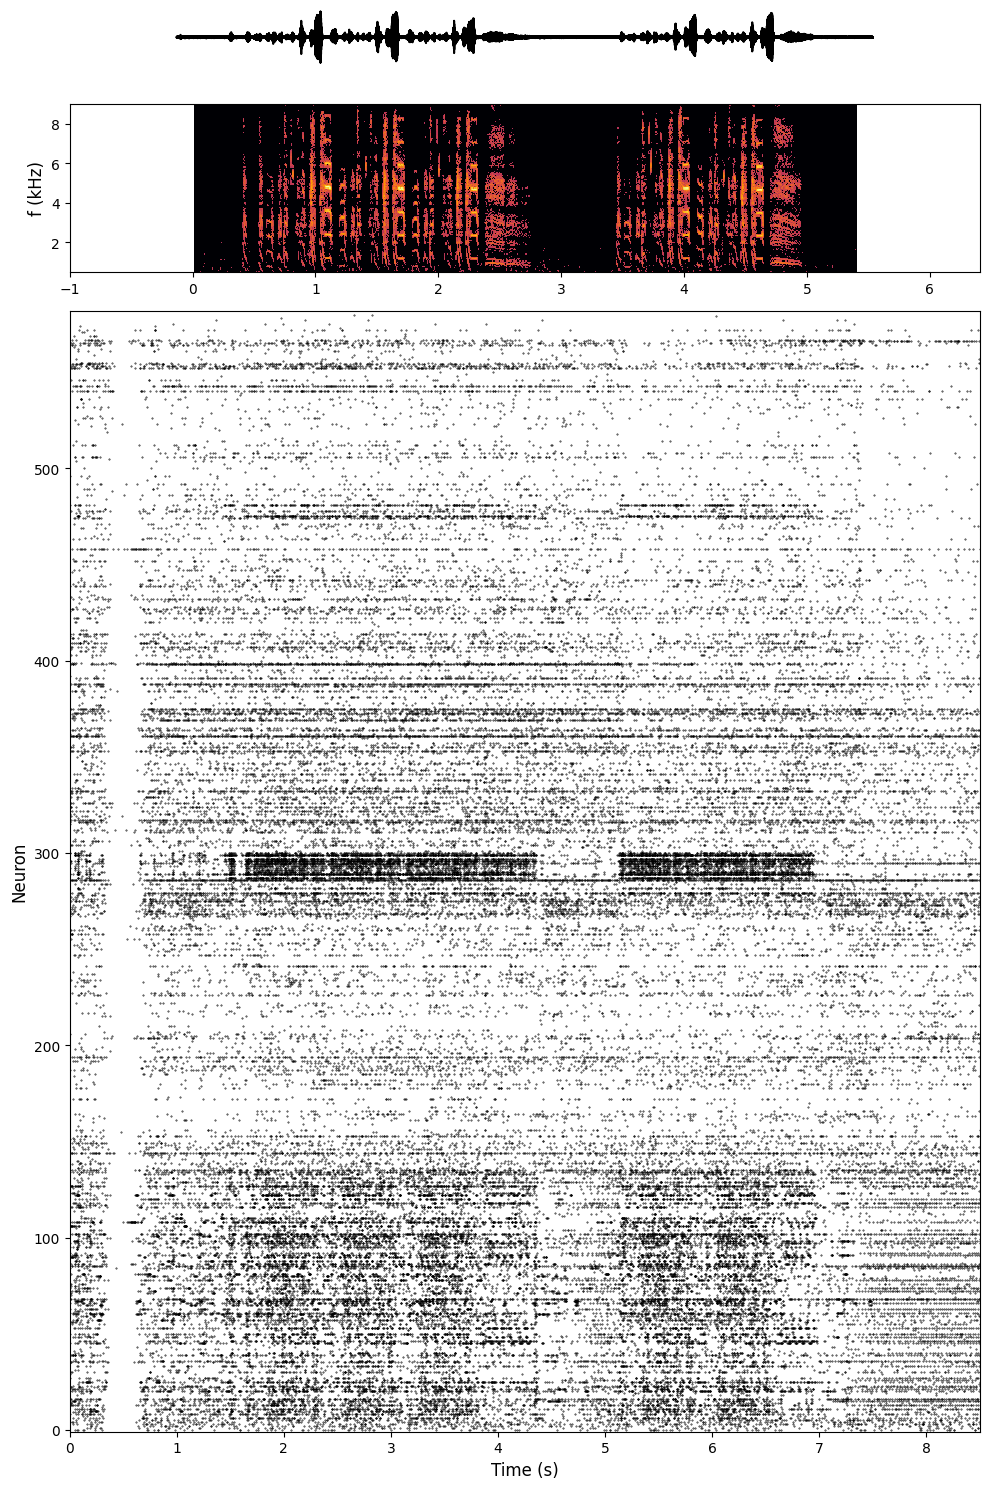

In [23]:
# plot bout with raster
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 3, 20]}, figsize=(10, 15))

# plot sonogram
ax[0].plot(waveform.flatten(), 'black')
ax[0].set_xlim([-trail_front*bout_fs, len(waveform.flatten())+trail_end*bout_fs])
ax[0].set_axis_off()

# plot spectrogram
f, t, sxx = make_spec(waveform.flatten(), fs)
ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax[1].set_xlim([-trail_front, t[-1]+trail_end])
ax[1].tick_params(axis='x', labelsize=10)
ax[1].set_ylabel('f (kHz)', fontsize=12)
ax[1].set_yticks([0,2000, 4000, 6000, 8000])
ax[1].set_yticklabels(['0', '2', '4', '6', '8'], fontsize=10)
ax[1].set_ylim([500, 9000])

# plot spike raster
x_trial, x_time = np.where(spike_arr>0)
ax[2].plot(x_time, x_trial, '.', color='k', markersize=0.75, rasterized=True)
# for row in ra_list:
#     ax[2].plot(x_time[x_trial == row], x_trial[x_trial == row], '.', color='r', markersize=0.75, rasterized=True)
# for row in hvc_list:
#     ax[2].plot(x_time[x_trial == row], x_trial[x_trial == row], '.', color='b', markersize=0.75, rasterized=True)
ax[2].set_xlim(0, spike_arr.shape[1])
ax[2].set_ylim(-1, spike_arr.shape[0] + 1)
ax[2].set_xticks(np.arange(0, spike_arr.shape[1], fs).tolist())
ax[2].set_xticklabels([str(int(e)) for e in np.arange(0,np.ceil(spike_arr.shape[1]/fs))])
ax[2].set_xlabel('Time (s)', fontsize=12)
ax[2].set_ylabel('Neuron', fontsize=12)
plt.tight_layout()

## Label nuclei

In [364]:
spk_df['nucleus'] = None

In [387]:
spk_df.loc[(spk_df.index >= min(hvc_rows)) & (spk_df.index <= max(hvc_rows)) & 
           (spk_df['quality_label'] != 'noise'), 'nucleus'] = 'HVC'

In [388]:
spk_df.loc[(spk_df.index >= min(ra_rows)) & (spk_df.index <= max(ra_rows)) & 
           (spk_df['quality_label'] != 'noise'), 'nucleus'] = 'RA'

In [389]:
print(len(spk_df[spk_df['nucleus']=='HVC']),'neurons in HVC,',len(spk_df[spk_df['nucleus']=='RA']),'neurons in RA')

41 neurons in HVC, 117 neurons in RA


## Save curated spikes

In [398]:
with open(os.path.join(sort_dir, 'spk_df.pickle'), 'wb') as handle:
    pickle.dump(spk_df, handle)